# ARIMA model for predict today's tesla stock price (yejin)

- reference 

: https://www.youtube.com/watch?v=rsva2qmhGyE (Predict Stock Price using ARIMA model (Python))

: https://www.youtube.com/watch?v=gqryqIlvEoM (How to Choose the p, d, q Terms to Build ARIMA Model)

- Python(pyenv 3.11.11)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from time import time
import datetime
import warnings

warnings.filterwarnings("ignore")

# 1. Fetch the data

In [2]:
#import tesla data
ticker = 'TSLA'
data = yf.Ticker(ticker)
data

yfinance.Ticker object <TSLA>

In [3]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=730)
tomorrow = end_date + datetime.timedelta(days=1)
prices = data.history(start=start_date,end=end_date).Close
# prices

In [4]:
print(end_date)
print(tomorrow)

2025-03-27
2025-03-28


# Stationary 

### ADF test (Augumented Dickey Fuller test) to check if the price series is stationary. 

Null hypothesis of the ADF test : time series is non-stationary.
So, if the p-value of the test is less than the significance level(0.05) then we can reject the null hypothesis and fer that time series is indeed stationary. 

In [5]:
#check if price series is stationary 
from statsmodels.tsa.stattools import adfuller

result = adfuller(prices.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -1.6520641531781293
p-value: 0.4559641310670286


### interpretation : p-value is clearly high, it means this time series is non stationary.
in our case, the p-value > 0.05 we'll need fo find the order of differencing.

# 2. Split train and test data

In [6]:
train = data.history(start='2023-01-01',end='2024-12-31')
test = data.history(start='2025-01-01',end='2025-12-31')

# 3. Find the (p,d,q) order based on auto_arima

In [7]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(train['Close'],
                          start_p=1, start_q=1,
                          max_p=5, max_q=5,
                          d=1,
                          seasonal=True,
                          m=12,  # 월별 주기면 12
                          trace=True,
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=3576.527, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3573.902, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3577.050, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3577.042, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3574.487, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3575.788, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3575.802, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3573.087, Time=0.37 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=3573.783, Time=0.77 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3576.661, Time=0.67 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3575.725, Time=0.49 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3575.561, Time=0.24 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=3574.769, Time=0.70 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3574.527, Time=0.54 sec
 ARIMA(0,1,1)(1,0,1

### Best model:  ARIMA(0,1,0)(1,0,1)

In [8]:
model = ARIMA(train['Close'], order=(1,0,1))
fitted = model.fit()
fitted.summary()

forecast = fitted.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_mean.index = test.index

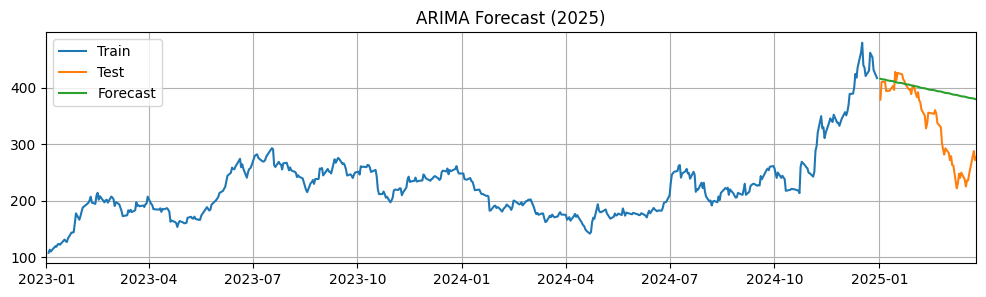

In [9]:
# test 길이만큼 미래 예측
n_periods = len(test)
forecast = fitted.get_forecast(steps=n_periods)
forecast_mean = forecast.predicted_mean

# 예측값 인덱스를 실제 2025년 날짜로 맞춰주기
forecast_mean.index = test.index

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3)) 
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, forecast_mean, label='Forecast')

plt.xlim(pd.to_datetime('2023-01-01'), test.index[-1])
plt.legend()
plt.title("ARIMA Forecast (2025)")
plt.grid(True)
plt.show()

# Performance evaluation

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = test['Close']
y_pred = forecast_mean

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MSE
mse = mean_squared_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mse)

print(f"ARIMA Model Evaluation:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


ARIMA Model Evaluation:
MAE:  63.93
MSE:  6925.83
RMSE: 83.22


In [11]:
# create empty pandas dataframe 

matrix = pd.DataFrame(columns=['MAE','MSE','RMSE'])

# fill out the matrix with the results of the ARIMA model
matrix.loc['ARIMA'] = [mae,mse,rmse]

matrix



,MAE,MSE,RMSE
ARIMA,63.930755,6925.833442,83.221592


In [12]:
import pickle

# save matrix to pickle file
with open("results_matrix.pkl", "wb") as f:
    pickle.dump(matrix, f)

In [13]:
#prediction the next day price
next_day_price = fitted.forecast(100,alpha=0.05) # next 100days prediction, 95% of confidence level 
print(next_day_price)

501    416.111047
502    415.407890
503    414.707304
504    414.009280
505    413.313810
          ...    
596    359.594015
597    359.097551
598    358.602902
599    358.110063
600    357.619025
Name: predicted_mean, Length: 100, dtype: float64


In [14]:
predicted_price= next_day_price.values[0]
print(f"The predicted_price for {tomorrow} tomorrow:", predicted_price)

The predicted_price for 2025-03-28 tomorrow: 416.1110474108897
